In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv(r"C:\Users\Saidabrorkhon\Downloads\WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [14]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [43]:
df['EmployeeCount'].nunique()

1

In [24]:
x = df.drop("Attrition", axis=1)
y = df['Attrition']
y = y.map({"Yes": 1, "No": 0})

num_cols = x.select_dtypes(include=["int64", "float64"]).columns
cat_cols = x.select_dtypes(include=["object", "category"]).columns

num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [34]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(verbosity= -1)
}

results = {}

#Train models inside pipeline and evaluate
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {
        "model": pipe,
        "accuracy": acc,
        "report": classification_report(y_test, y_pred, output_dict=True)
    }
    print(f"{name} Accuracy: {acc:.4f}")

best_model_name = max(results, key=lambda x: results[x]["accuracy"])
best_model = results[best_model_name]["model"]
y_pred_best = best_model.predict(x_test)


print(f"Best Model: {best_model_name}")
print(classification_report(y_test, y_pred_best))

LogisticRegression Accuracy: 0.8605
RandomForest Accuracy: 0.8469
XGBoost Accuracy: 0.8741
LightGBM Accuracy: 0.8639
Best Model: XGBoost
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       247
           1       0.81      0.28      0.41        47

    accuracy                           0.87       294
   macro avg       0.85      0.63      0.67       294
weighted avg       0.87      0.87      0.85       294



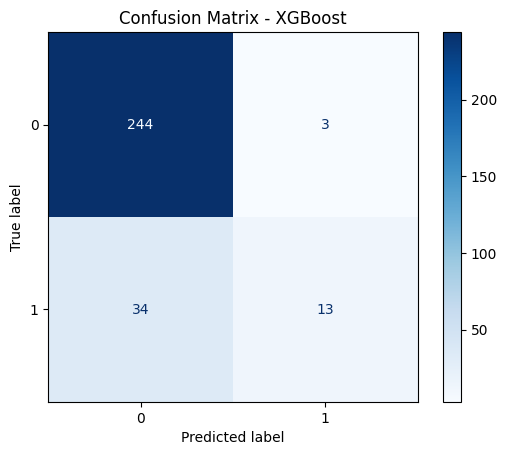

In [28]:
ConfusionMatrixDisplay.from_estimator(best_model, x_test, y_test, cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

In [ ]:
df_results = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": [v["accuracy"] for v in results.values()]
})

df_results = df_results.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
df_results

,Model,Accuracy
0,XGBoost,0.874150
1,LightGBM,0.863946
2,LogisticRegression,0.860544
3,RandomForest,0.840136


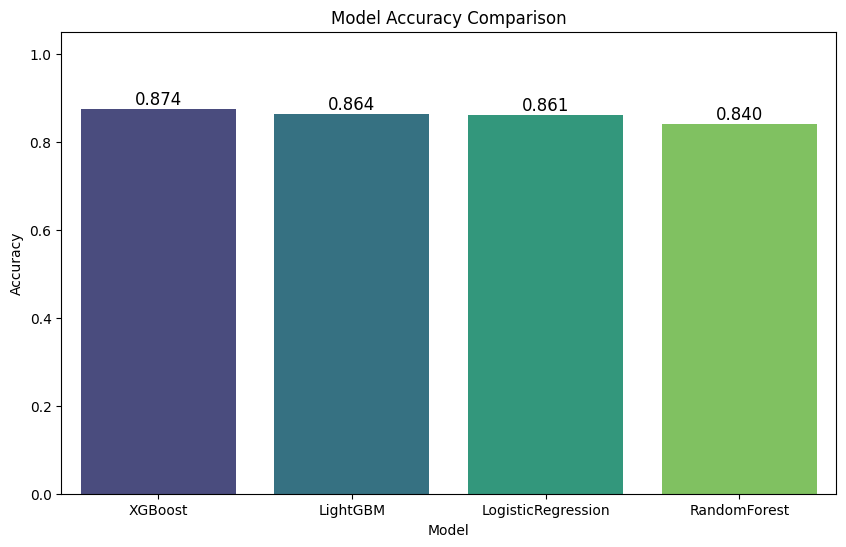

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x="Model", y="Accuracy", palette="viridis")

for i, acc in enumerate(df_results["Accuracy"]):
    plt.text(i, acc + 0.01, f"{acc:.3f}", ha='center', fontsize=12)

plt.title("Model Accuracy Comparison")
plt.ylim(0, 1.05)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.show()

In [35]:
import joblib
joblib.dump(best_model, 'best_model.joblib')

['best_model.joblib']